# The dataset can be downloaded from the following Kaggle link:
# https://www.kaggle.com/datasets/apexagotecha/sentimenttraindataset

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


READING THE FILE

In [2]:
file_path = '/kaggle/input/sentimenttraindataset/train_2kmZucJ.csv'
df = pd.read_csv(file_path, index_col = 'id')
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


PREPROCESSING THE DATASET

In [3]:
# 1st Step: Building the standardize text
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT[\s]+', '', text)
    
    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Hashtags removal
    text = re.sub(r'#', '', text)
    
    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case = False,
        strip_handles = True,
        reduce_len = True
    )
    
    text_tokens = tokenizer.tokenize(text)
    
    return text_tokens

In [4]:
# 2nd Step: Saving the frequency of each word
def get_freqs(df):
    # Declare an empty dictionary
    freqs = defaultdict(lambda:0)
    
    # Iterate dataframe to get indices and labels
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        
        # Normalize the current tweet
        tokens = text_normalize(tweet)
        
        # Iterate over each token (tuple)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    
    return freqs    

In [5]:
# 3rd Step: Building the characteristics vector
def get_feature(text, freqs):
    # Normalize the current tweet
    tokens = text_normalize(text)
    
    # Initialize a zero-vector size 3 (intercept, n_positives, n_negatives). X[0] is intercept, which is 1
    X = np.zeros(3)
    X[0] = 1
    
    # Iterate over each token, then add frequency to each label
    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]
    
    return X

In [6]:
# 4th: Get the final output
X = []
y = []

freqs = get_freqs(df)

for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']
    
    X_i = get_feature(tweet,freqs)
    
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

SPLIT DATASET FOR TRAIN/VAL/TEST

In [7]:
# Parameters for train/val/test
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

In [8]:
# Validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = val_size, random_state = random_state, shuffle = is_shuffle
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6336, 3), (1584, 3), (6336,), (1584,))

In [9]:
# Testing set
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size = test_size, random_state = random_state, shuffle = is_shuffle
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5544, 3), (792, 3), (5544,), (792,))

NORMALIZE THE DATA

In [10]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.fit_transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.fit_transform(X_test[:, 1:])

IMPORT ESSENTIAL FUNCTIONS FOR THIS MODEL

In [11]:
# Sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

In [12]:
# Predict the output
def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = sigmoid(z)
    return y_hat

In [13]:
# Compute loss
def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    loss = (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean()
    return -loss

In [14]:
# Compute gradient
def compute_gradient(X, y_hat, y):
    N = y.size 
    gradient = np.dot(X.T, y_hat - y)
    return gradient/N

In [15]:
# Update theta
def update_theta(theta, gradient, lr):
    theta = theta - lr*gradient
    return theta

In [16]:
# Compute accuracy
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    accuracy = (y_hat == y).mean()
    return accuracy

TRAINING THE MODEL

In [17]:
# Declare the hyperparameters
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size = X_train.shape[1])

In [18]:
# Training model
train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]
        
        ##### Training set #####
        
        # Predict output
        y_hat = predict(X_i, theta)
        
        # Compute loss
        train_loss = compute_loss(y_hat, y_i)
        train_batch_losses.append(train_loss)
        
        # Compute gradient
        gradient = compute_gradient(X_i, y_hat, y_i)
        
        # Update theta
        theta = update_theta(theta, gradient, lr)
        
        # Compute accuracy
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)
        
        ##### Validation set #####
        
        # Predict output
        y_val_hat = predict(X_val, theta)
        
        # Compute loss
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)
        
        # Compute accuracy
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    # Training set
    train_batch_acc = sum(train_batch_accs)/len(train_batch_accs)
    train_accs.append(train_batch_acc)
    train_batch_loss = sum(train_batch_losses)/len(train_batch_losses)
    train_losses.append(train_batch_loss)
    
    # Validation set
    val_batch_acc = sum(val_batch_accs)/len(val_batch_accs)
    val_accs.append(val_batch_acc)
    val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    val_losses.append(val_batch_loss)
    
    # Printing the result
    print(f'\tEpoch: {epoch + 1}:\tTraining batch loss: {train_batch_acc:.3f} \tValidation batch loss: {val_batch_loss:.3f}')

	Epoch: 1:	Training batch loss: 0.556 	Validation batch loss: 0.700
	Epoch: 2:	Training batch loss: 0.631 	Validation batch loss: 0.654
	Epoch: 3:	Training batch loss: 0.692 	Validation batch loss: 0.618
	Epoch: 4:	Training batch loss: 0.733 	Validation batch loss: 0.587
	Epoch: 5:	Training batch loss: 0.761 	Validation batch loss: 0.563
	Epoch: 6:	Training batch loss: 0.775 	Validation batch loss: 0.542
	Epoch: 7:	Training batch loss: 0.785 	Validation batch loss: 0.525
	Epoch: 8:	Training batch loss: 0.793 	Validation batch loss: 0.511
	Epoch: 9:	Training batch loss: 0.797 	Validation batch loss: 0.499
	Epoch: 10:	Training batch loss: 0.802 	Validation batch loss: 0.489
	Epoch: 11:	Training batch loss: 0.806 	Validation batch loss: 0.480
	Epoch: 12:	Training batch loss: 0.809 	Validation batch loss: 0.473
	Epoch: 13:	Training batch loss: 0.809 	Validation batch loss: 0.466
	Epoch: 14:	Training batch loss: 0.811 	Validation batch loss: 0.461
	Epoch: 15:	Training batch loss: 0.811 	Val

PLOT THE FIGURES

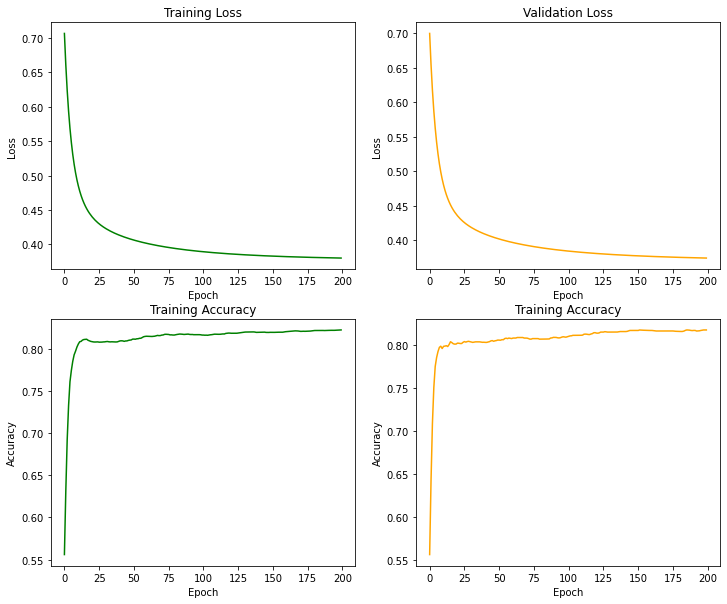

In [19]:
fig, ax = plt.subplots(2,2,figsize = (12,10))

ax[0,0].plot(train_losses, 'green')
ax[0,0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses, 'orange')
ax[0,1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs, 'green')
ax[1,0].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs, 'orange')
ax[1,1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1,1].set_title('Training Accuracy')

plt.show()

EVALUATE THE MODEL

In [20]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on two sets:')
print(f'Validation set: {val_set_acc}')
print(f'Testing set: {test_set_acc}')

Evaluation on two sets:
Validation set: 0.8175505050505051
Testing set: 0.8446969696969697
